### Data Dictionary


    credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
    
    purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
    
    int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
    
    installment: The monthly installments () owed by the borrower if the loan is funded.
    
    log.annual.inc: The natural log of the self-reported annual income of the borrower.
    
    dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
    
    fico: The FICO credit score of the borrower.
    
    days.with.cr.line: The number of days the borrower has had a credit line.
    
    revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
    
    revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
    
    inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
    
    delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
    
    pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).


The binary dependent variable not.fully.paid indicates that the loan was not paid back in full (the borrower either defaulted or the loan was "charged off," meaning the borrower was deemed unlikely to ever pay it back).

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("loans.csv",encoding='ISO-8859-1')

In [3]:
df

,creditpolicy,purpose,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2.0,0.0,0.0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5.0,0.0,0.0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8.0,0.0,0.0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5.0,0.0,0.0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   creditpolicy    9578 non-null   int64  
 1   purpose         9578 non-null   object 
 2   intrate         9578 non-null   float64
 3   installment     9578 non-null   float64
 4   logannualinc    9574 non-null   float64
 5   dti             9578 non-null   float64
 6   fico            9578 non-null   int64  
 7   dayswithcrline  9549 non-null   float64
 8   revolbal        9578 non-null   int64  
 9   revolutil       9516 non-null   float64
 10  inqlast6mths    9549 non-null   float64
 11  delinq2yrs      9549 non-null   float64
 12  pubrec          9549 non-null   float64
 13  notfullypaid    9578 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 1.0+ MB


In [5]:
df.describe(include='all')

,creditpolicy,purpose,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
count,9578.000000,9578,9578.000000,9578.000000,9574.000000,9578.000000,9578.000000,9549.000000,9.578000e+03,9516.000000,9549.000000,9549.000000,9549.000000,9578.000000
unique,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,debt_consolidation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,3957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.804970,NaN,0.122640,319.089413,10.931874,12.606679,710.846314,4562.026085,1.691396e+04,46.865677,1.571578,0.163787,0.062101,0.160054
std,0.396245,NaN,0.026847,207.071301,0.614736,6.883970,37.970537,2497.985733,3.375619e+04,29.018642,2.198095,0.546712,0.262152,0.366676
min,0.000000,NaN,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,NaN,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.700000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,NaN,0.122100,268.950000,10.927987,12.665000,707.000000,4139.958333,8.596000e+03,46.400000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,NaN,0.140700,432.762500,11.289832,17.950000,737.000000,5730.000000,1.824950e+04,71.000000,2.000000,0.000000,0.000000,0.000000


In [6]:
df.shape

(9578, 14)

In [7]:
df.columns

Index(['creditpolicy', 'purpose', 'intrate', 'installment', 'logannualinc',
       'dti', 'fico', 'dayswithcrline', 'revolbal', 'revolutil',
       'inqlast6mths', 'delinq2yrs', 'pubrec', 'notfullypaid'],
      dtype='object')

### Data Visualization

In [8]:
df['notfullypaid'].value_counts()

0    8045
1    1533
Name: notfullypaid, dtype: int64

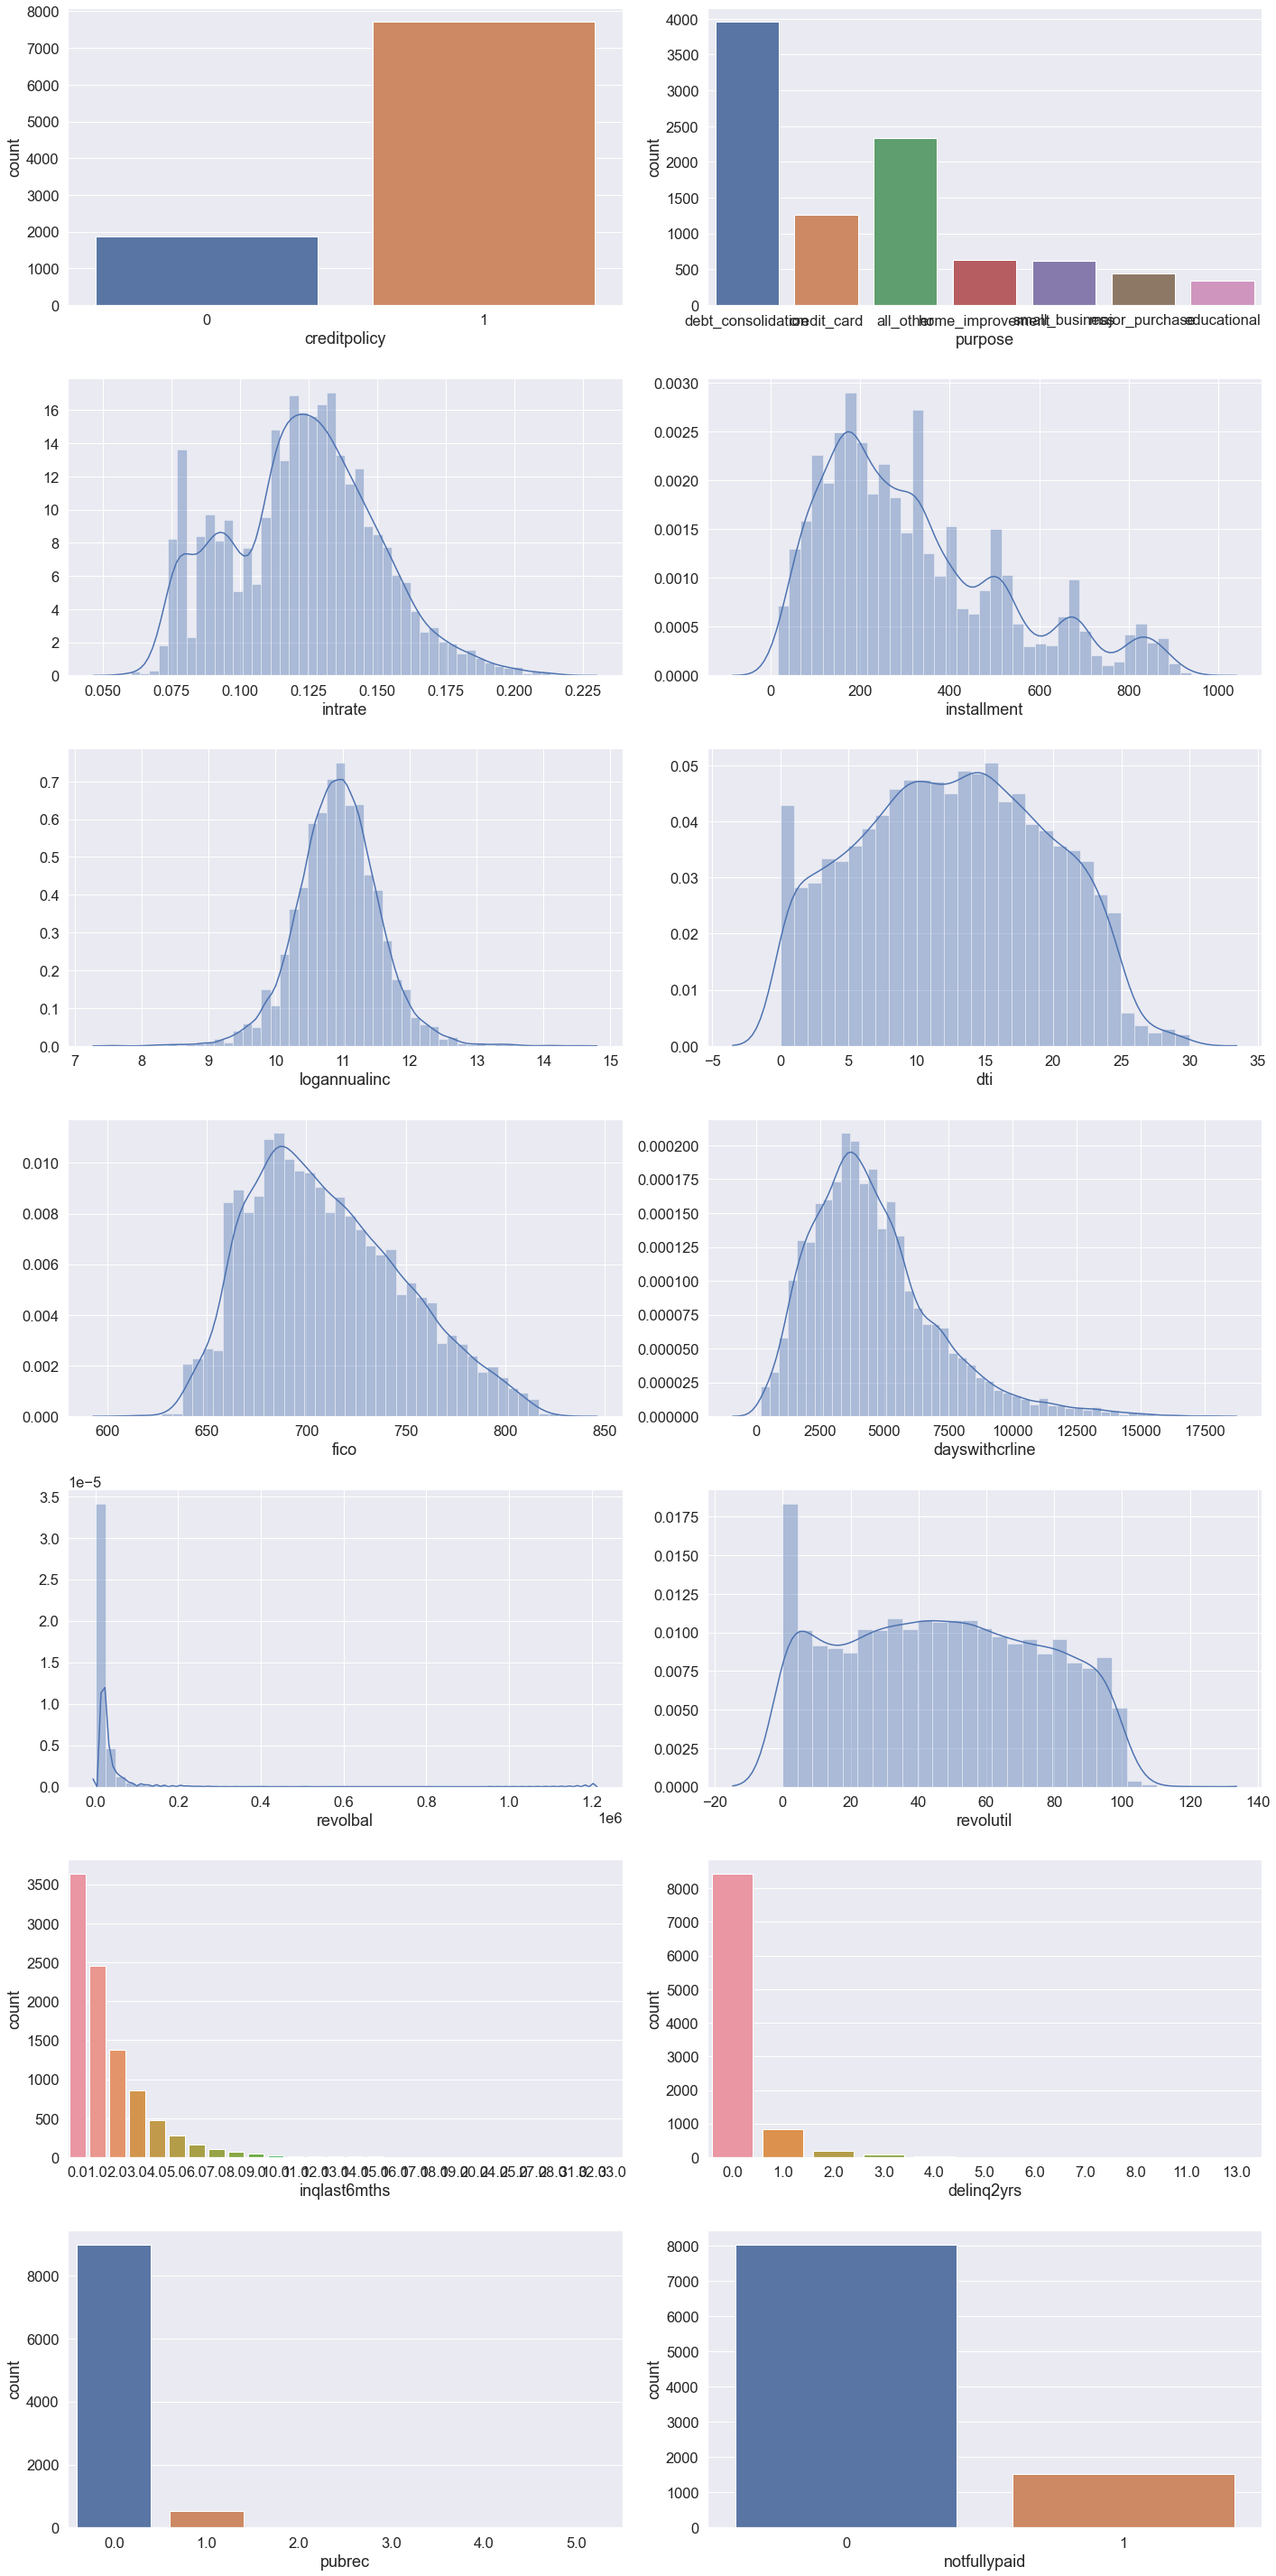

In [9]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.creditpolicy)

plt.subplot(7,2,2)
sns.countplot(df.purpose)
plt.subplot(7,2,3)
sns.distplot(df.intrate)
plt.subplot(7,2,4)
sns.distplot(df.installment)
plt.subplot(7,2,5)
sns.distplot(df.logannualinc)
plt.subplot(7,2,6)
sns.distplot(df.dti)
plt.subplot(7,2,7)
sns.distplot(df.fico)
plt.subplot(7,2,8)
sns.distplot(df.dayswithcrline)
plt.subplot(7,2,9)
sns.distplot(df.revolbal)
plt.subplot(7,2,10)
sns.distplot(df.revolutil)
plt.subplot(7,2,11)
sns.countplot(df.inqlast6mths)
plt.subplot(7,2,12)
sns.countplot(df.delinq2yrs)
plt.subplot(7,2,13)
sns.countplot(df.pubrec)
plt.subplot(7,2,14)
sns.countplot(df.notfullypaid)

plt.tight_layout()
plt.show()

In [10]:
df.corr()

,creditpolicy,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
creditpolicy,1.000000,-0.294089,0.058770,0.035752,-0.090901,0.348319,0.098730,-0.187518,-0.109876,-0.534757,-0.077141,-0.054501,-0.158119
intrate,-0.294089,1.000000,0.276140,0.057119,0.220006,-0.714821,-0.124505,0.092527,0.463864,0.206677,0.156080,0.098394,0.159552
installment,0.058770,0.276140,1.000000,0.448523,0.050202,0.086039,0.183263,0.233625,0.079541,-0.008099,-0.004720,-0.032639,0.049955
logannualinc,0.035752,0.057119,0.448523,1.000000,-0.053434,0.113733,0.336077,0.372481,0.056112,0.028432,0.029409,0.016377,-0.033279
dti,-0.090901,0.220006,0.050202,-0.053434,1.000000,-0.241191,0.060231,0.188748,0.336578,0.031135,-0.022085,0.006102,0.037362
fico,0.348319,-0.714821,0.086039,0.113733,-0.241191,1.000000,0.263685,-0.015553,-0.541113,-0.187682,-0.216481,-0.147389,-0.149666
dayswithcrline,0.098730,-0.124505,0.183263,0.336077,0.060231,0.263685,1.000000,0.229430,-0.024019,-0.042029,0.081707,0.071336,-0.028889
revolbal,-0.187518,0.092527,0.233625,0.372481,0.188748,-0.015553,0.229430,1.000000,0.203002,0.023805,-0.033348,-0.031026,0.053699
revolutil,-0.109876,0.463864,0.079541,0.056112,0.336578,-0.541113,-0.024019,0.203002,1.000000,-0.011377,-0.042905,0.067375,0.082041
inqlast6mths,-0.534757,0.206677,-0.008099,0.028432,0.031135,-0.187682,-0.042029,0.023805,-0.011377,1.000000,0.021183,0.073984,0.149954


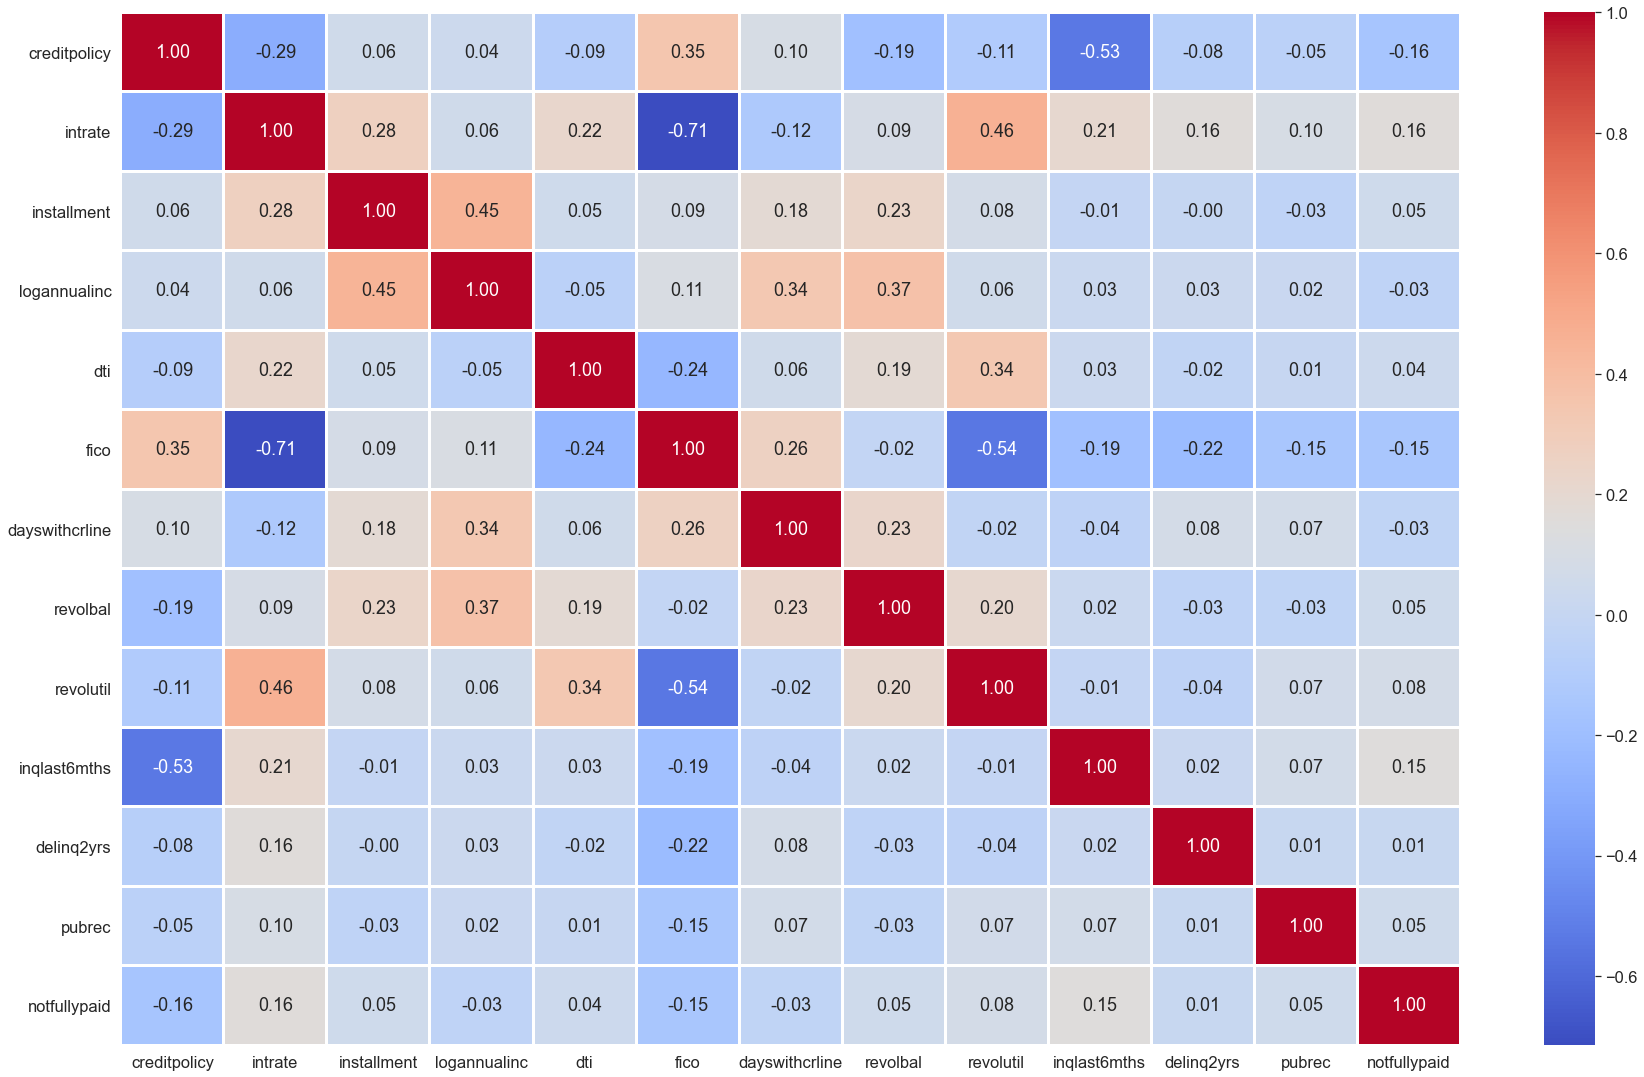

In [11]:
plt.figure(figsize=(30,19))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

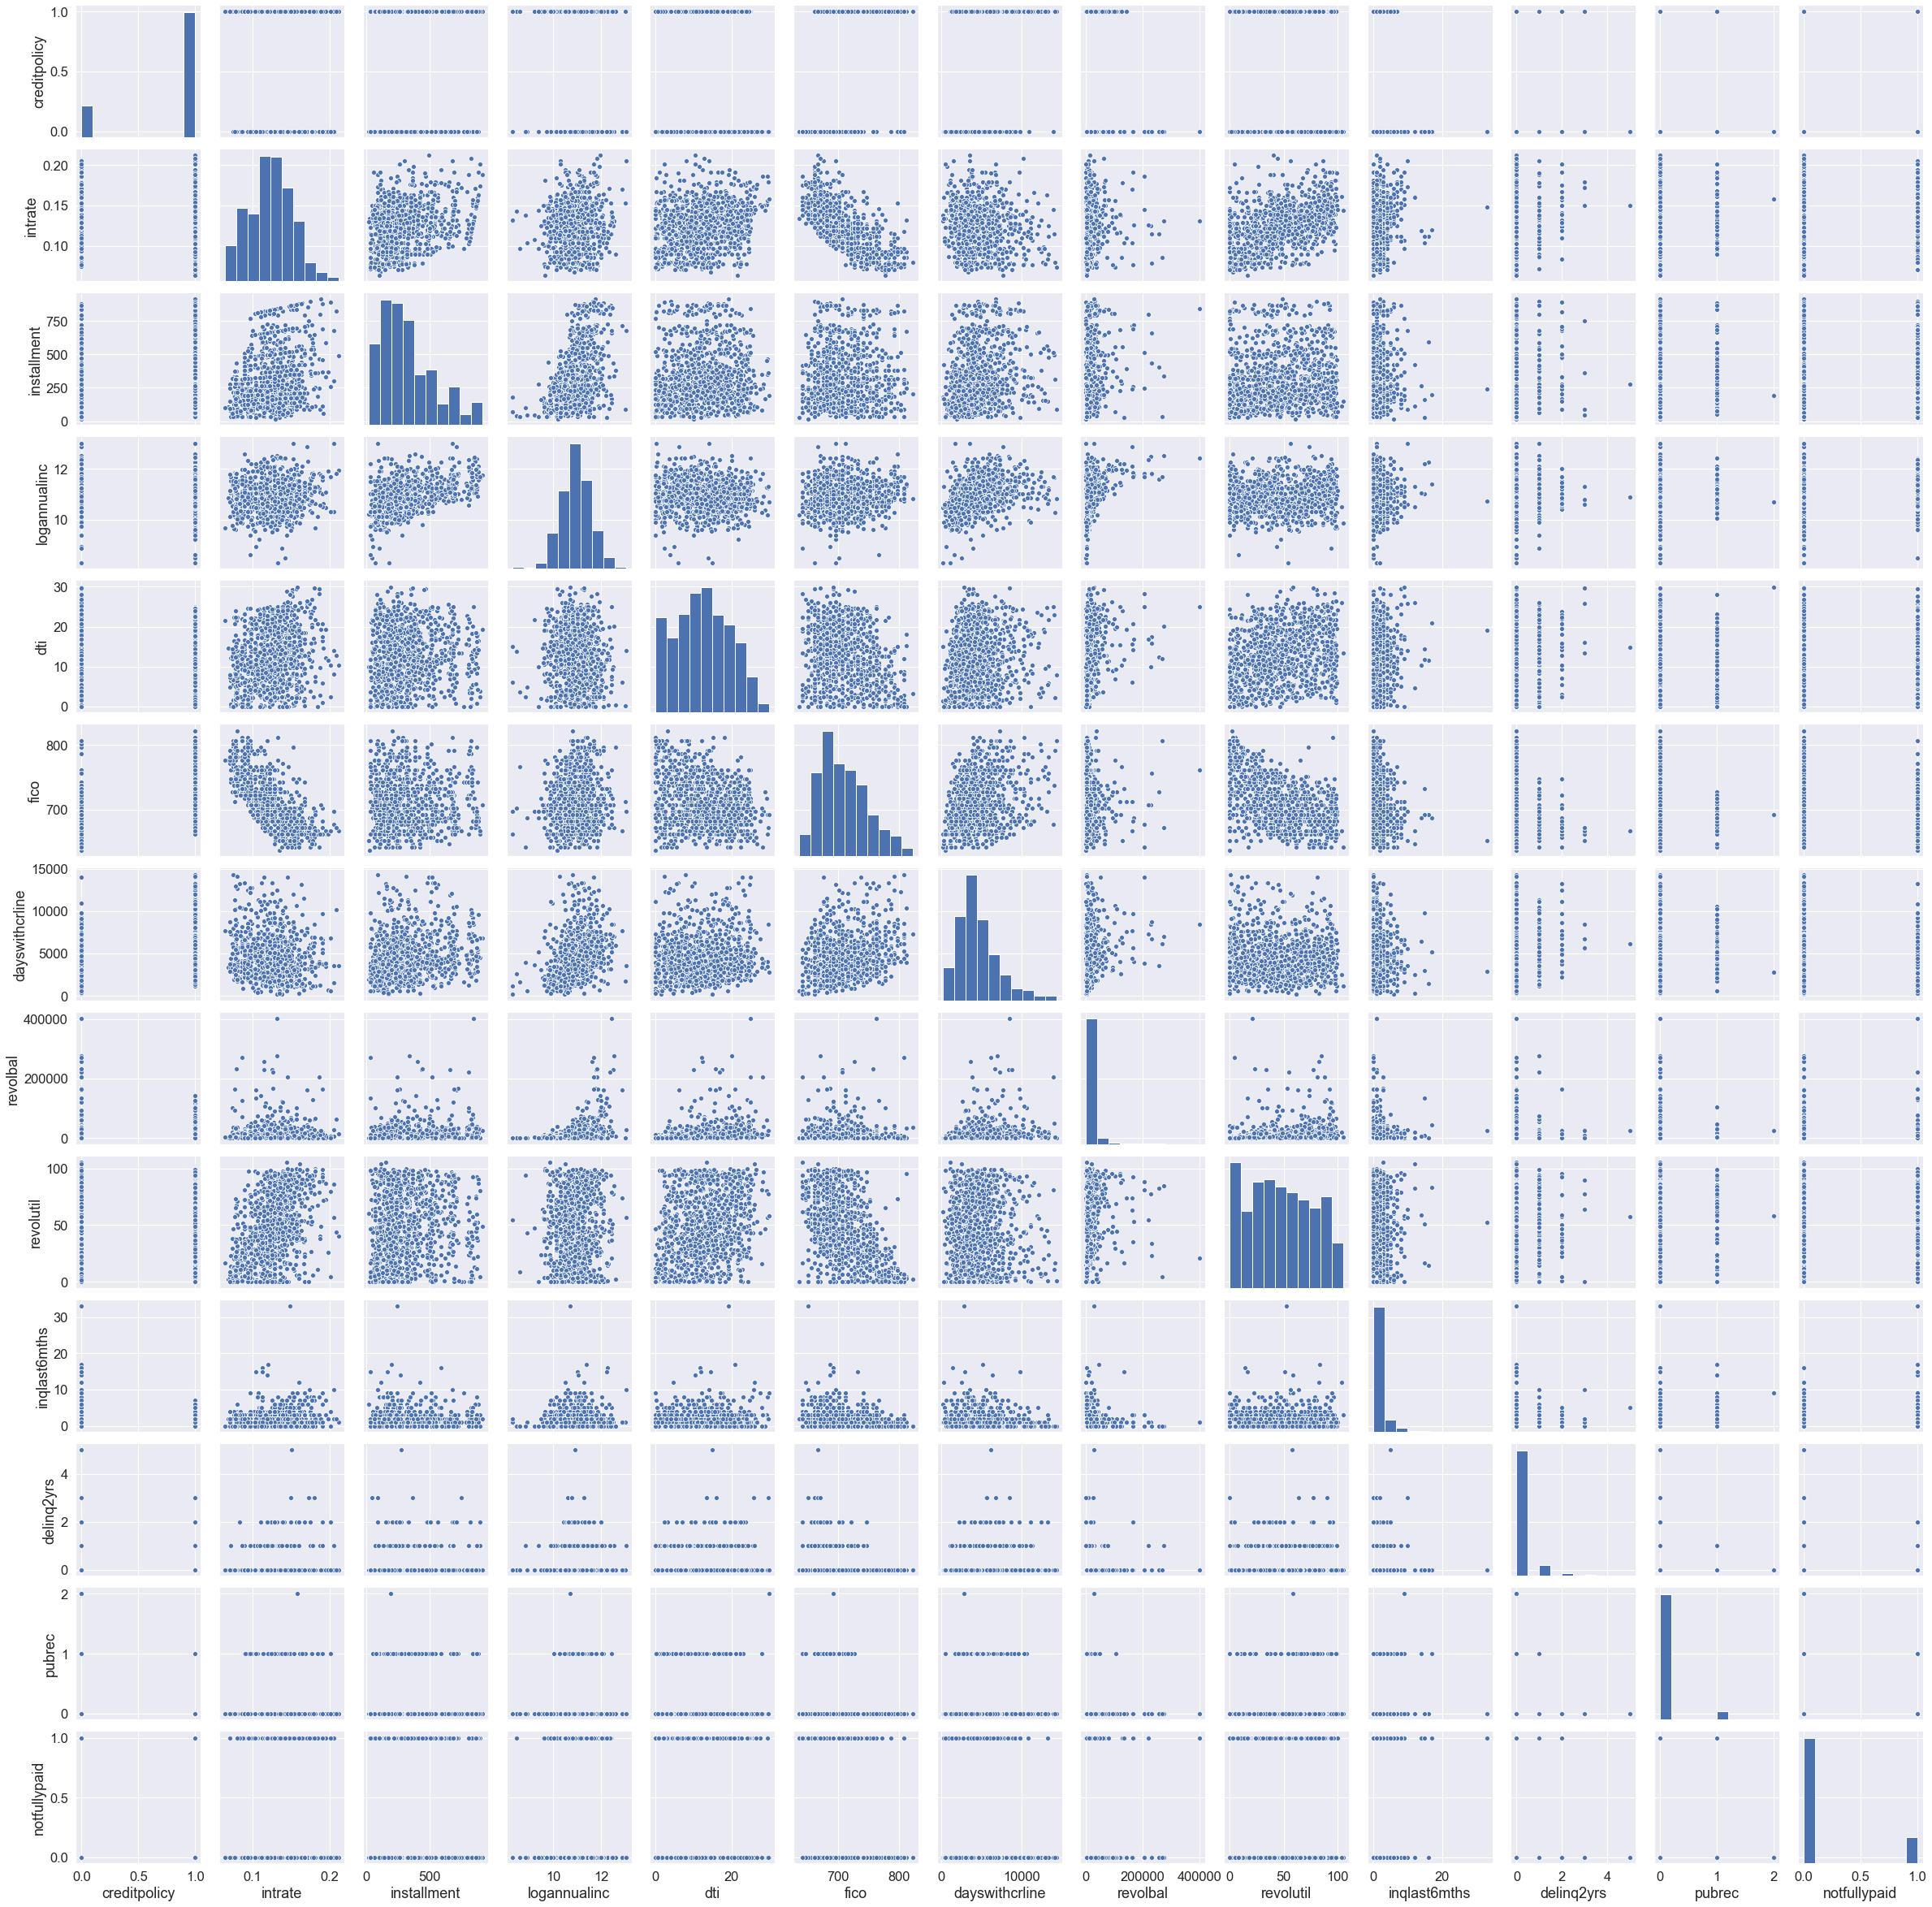

In [12]:
sns.pairplot(df.sample(1000))
plt.show()

### Data Preprocessing

### Treat Missing Values

In [13]:
df.isnull().sum()

creditpolicy       0
purpose            0
intrate            0
installment        0
logannualinc       4
dti                0
fico               0
dayswithcrline    29
revolbal           0
revolutil         62
inqlast6mths      29
delinq2yrs        29
pubrec            29
notfullypaid       0
dtype: int64

In [14]:
imputer = mdi.MeanMedianImputer(imputation_method='median',variables=['logannualinc','dayswithcrline','revolutil','inqlast6mths',
                               'delinq2yrs','pubrec'])

In [15]:
df2 = imputer.fit_transform(df)

In [16]:
df2

,creditpolicy,purpose,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2.0,0.0,0.0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5.0,0.0,0.0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8.0,0.0,0.0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5.0,0.0,0.0,1


In [17]:
df2.isnull().sum()

creditpolicy      0
purpose           0
intrate           0
installment       0
logannualinc      0
dti               0
fico              0
dayswithcrline    0
revolbal          0
revolutil         0
inqlast6mths      0
delinq2yrs        0
pubrec            0
notfullypaid      0
dtype: int64

### Treat Duplicate Values

In [18]:
df2.duplicated(keep='first').sum()

0

### Treat Imbalance Data

In [19]:
notpaid = df2[df2['notfullypaid'] == 1]

In [20]:
notpaid

,creditpolicy,purpose,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
6,1,debt_consolidation,0.1496,194.02,10.714418,4.00,667,3180.041667,3839,76.8,0.0,0.0,1.0,1
7,1,all_other,0.1114,131.22,11.002100,11.08,722,5116.000000,24220,68.6,0.0,0.0,0.0,1
57,1,credit_card,0.1343,678.08,11.884489,10.15,682,4209.958333,41674,74.1,0.0,0.0,0.0,1
65,1,all_other,0.1059,32.55,10.433822,14.47,687,1110.000000,4485,36.9,1.0,0.0,0.0,1
73,1,small_business,0.1501,225.37,12.269047,6.45,677,6240.000000,56411,75.3,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2.0,0.0,0.0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5.0,0.0,0.0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8.0,0.0,0.0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5.0,0.0,0.0,1


In [21]:
paid = df2[df2['notfullypaid'] == 0]

In [22]:
paid

,creditpolicy,purpose,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9561,0,all_other,0.0788,115.74,10.999095,10.17,722,4410.000000,11586,61.6,4.0,0.0,0.0,0
9562,0,debt_consolidation,0.1348,508.87,10.933107,17.76,717,3870.041667,8760,28.2,6.0,0.0,0.0,0
9564,0,all_other,0.1385,511.56,12.323856,12.33,687,6420.041667,385489,51.2,4.0,0.0,0.0,0
9567,0,all_other,0.1311,101.24,10.968198,8.23,687,2790.041667,1514,13.8,5.0,0.0,0.0,0


In [23]:
paid = paid.sample(n=1533)

In [24]:
paid

,creditpolicy,purpose,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
4963,1,debt_consolidation,0.1218,532.80,11.002100,16.40,712,6960.000000,12295,38.5,0.0,0.0,0.0,0
3644,1,small_business,0.1884,438.93,10.819778,12.60,712,3690.000000,11957,43.5,2.0,0.0,0.0,0
5532,1,credit_card,0.1183,298.21,11.184421,19.50,737,4500.000000,12893,90.8,1.0,0.0,0.0,0
4318,1,all_other,0.0894,381.26,11.608236,7.30,807,4979.958333,1,0.1,0.0,0.0,0.0,0
1566,1,debt_consolidation,0.1020,161.81,11.050890,11.09,717,3600.000000,836,9.2,3.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7257,1,debt_consolidation,0.1273,805.59,11.367900,15.27,722,5340.041667,9138,62.2,0.0,0.0,0.0,0
6701,1,credit_card,0.1253,669.33,11.369863,20.13,717,6210.000000,51324,63.6,0.0,0.0,0.0,0
6602,1,debt_consolidation,0.1025,647.70,10.714418,4.11,747,3183.041667,5081,40.0,0.0,0.0,0.0,0
1496,1,debt_consolidation,0.1083,293.93,10.558414,17.86,737,2670.041667,0,0.0,1.0,0.0,0.0,0


In [25]:
df3 = pd.concat([paid,notpaid],axis=0)

In [26]:
df3

,creditpolicy,purpose,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
4963,1,debt_consolidation,0.1218,532.80,11.002100,16.40,712,6960.000000,12295,38.5,0.0,0.0,0.0,0
3644,1,small_business,0.1884,438.93,10.819778,12.60,712,3690.000000,11957,43.5,2.0,0.0,0.0,0
5532,1,credit_card,0.1183,298.21,11.184421,19.50,737,4500.000000,12893,90.8,1.0,0.0,0.0,0
4318,1,all_other,0.0894,381.26,11.608236,7.30,807,4979.958333,1,0.1,0.0,0.0,0.0,0
1566,1,debt_consolidation,0.1020,161.81,11.050890,11.09,717,3600.000000,836,9.2,3.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2.0,0.0,0.0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5.0,0.0,0.0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8.0,0.0,0.0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5.0,0.0,0.0,1


In [27]:
df3 = df3.sample(frac=1).reset_index(drop=True)

In [28]:
df3

,creditpolicy,purpose,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
0,0,debt_consolidation,0.1375,166.88,10.680516,3.01,647,1260.000000,1893,90.1,2.0,0.0,1.0,1
1,1,credit_card,0.0963,288.85,11.608236,18.41,737,3481.041667,2737,6.4,1.0,0.0,0.0,1
2,1,home_improvement,0.1287,168.17,10.874266,16.57,682,3644.958333,1465,63.7,1.0,0.0,0.0,1
3,0,major_purchase,0.1330,84.60,10.125030,0.96,652,180.041667,177,88.5,1.0,0.0,0.0,1
4,1,major_purchase,0.1496,207.87,10.596635,8.49,662,4043.000000,2998,19.1,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,1,debt_consolidation,0.1533,870.71,12.611538,16.16,692,8220.041667,89620,76.6,0.0,0.0,0.0,0
3062,1,small_business,0.0976,644.71,10.165852,9.14,762,6752.041667,507,3.5,0.0,0.0,0.0,1
3063,0,small_business,0.1565,349.85,11.184421,28.40,692,4470.041667,60134,53.0,5.0,0.0,1.0,1
3064,1,debt_consolidation,0.1322,162.25,10.714418,15.17,677,3123.041667,6354,74.8,0.0,0.0,0.0,0


In [29]:
df3['notfullypaid'].value_counts()

1    1533
0    1533
Name: notfullypaid, dtype: int64

### Treat Outliers

In [30]:
df3.columns

Index(['creditpolicy', 'purpose', 'intrate', 'installment', 'logannualinc',
       'dti', 'fico', 'dayswithcrline', 'revolbal', 'revolutil',
       'inqlast6mths', 'delinq2yrs', 'pubrec', 'notfullypaid'],
      dtype='object')

In [31]:
df3.describe()

,creditpolicy,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
count,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000,3.066000e+03,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000
mean,0.741683,0.126778,331.989136,10.921971,12.910652,705.551859,4489.274000,1.885953e+04,49.032508,1.872798,0.179387,0.076973,0.500000
std,0.437781,0.026838,213.787624,0.637429,6.971195,37.149758,2469.747867,4.164853e+04,28.905147,2.548095,0.561209,0.275026,0.500082
min,0.000000,0.070500,15.670000,7.547502,0.000000,617.000000,180.041667,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.109900,167.567500,10.545341,7.372500,677.000000,2819.010417,3.329750e+03,25.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.125750,282.735000,10.915088,13.120000,702.000000,4080.000000,8.747500e+03,49.200000,1.000000,0.000000,0.000000,0.500000
75%,1.000000,0.144200,471.435000,11.289782,18.350000,732.000000,5669.989583,1.885650e+04,73.300000,3.000000,0.000000,0.000000,1.000000
max,1.000000,0.216400,926.830000,14.528354,29.960000,822.000000,16350.000000,1.207359e+06,106.500000,33.000000,8.000000,2.000000,1.000000


In [32]:
windsorizer = Winsorizer(distribution='skewed',tail='both',fold=1.5,
                         variables=['intrate', 'installment', 'logannualinc','dti', 'fico', 
                                    'dayswithcrline', 'revolbal', 'revolutil','inqlast6mths'])

In [33]:
windsorizer.fit(df3)

Winsorizer(distribution='skewed', fold=1.5, tail='both',
           variables=['intrate', 'installment', 'logannualinc', 'dti', 'fico',
                      'dayswithcrline', 'revolbal', 'revolutil',
                      'inqlast6mths'])

In [34]:
df4 = windsorizer.transform(df3)

In [35]:
df4

,creditpolicy,purpose,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
0,0,debt_consolidation,0.1375,166.88,10.680516,3.01,647.0,1260.000000,1893.000,90.1,2.0,0.0,1.0,1
1,1,credit_card,0.0963,288.85,11.608236,18.41,737.0,3481.041667,2737.000,6.4,1.0,0.0,0.0,1
2,1,home_improvement,0.1287,168.17,10.874266,16.57,682.0,3644.958333,1465.000,63.7,1.0,0.0,0.0,1
3,0,major_purchase,0.1330,84.60,10.125030,0.96,652.0,180.041667,177.000,88.5,1.0,0.0,0.0,1
4,1,major_purchase,0.1496,207.87,10.596635,8.49,662.0,4043.000000,2998.000,19.1,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,1,debt_consolidation,0.1533,870.71,12.406443,16.16,692.0,8220.041667,42146.625,76.6,0.0,0.0,0.0,0
3062,1,small_business,0.0976,644.71,10.165852,9.14,762.0,6752.041667,507.000,3.5,0.0,0.0,0.0,1
3063,0,small_business,0.1565,349.85,11.184421,28.40,692.0,4470.041667,42146.625,53.0,5.0,0.0,1.0,1
3064,1,debt_consolidation,0.1322,162.25,10.714418,15.17,677.0,3123.041667,6354.000,74.8,0.0,0.0,0.0,0


In [36]:
df4.describe()

,creditpolicy,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,inqlast6mths,delinq2yrs,pubrec,notfullypaid
count,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000,3066.000000
mean,0.741683,0.126696,331.989136,10.921092,12.910652,705.544521,4416.766933,13237.560217,49.032508,1.753751,0.179387,0.076973,0.500000
std,0.437781,0.026608,213.787624,0.599245,6.971195,37.127645,2250.743919,12902.291123,28.905147,2.003959,0.561209,0.275026,0.500082
min,0.000000,0.070500,15.670000,9.428681,0.000000,617.000000,180.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.109900,167.567500,10.545341,7.372500,677.000000,2819.010417,3329.750000,25.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.125750,282.735000,10.915088,13.120000,702.000000,4080.000000,8747.500000,49.200000,1.000000,0.000000,0.000000,0.500000
75%,1.000000,0.144200,471.435000,11.289782,18.350000,732.000000,5669.989583,18856.500000,73.300000,3.000000,0.000000,0.000000,1.000000
max,1.000000,0.195650,926.830000,12.406443,29.960000,814.500000,9946.458333,42146.625000,106.500000,7.500000,8.000000,2.000000,1.000000


In [37]:
windsorizer.left_tail_caps_

{'intrate': 0.05845,
 'installment': -288.23375,
 'logannualinc': 9.428680734999999,
 'dti': -9.093750000000004,
 'fico': 594.5,
 'dayswithcrline': -1457.458333,
 'revolbal': -19960.375,
 'revolutil': -45.949999999999996,
 'inqlast6mths': -4.5}

In [38]:
windsorizer.right_tail_caps_

{'intrate': 0.19565,
 'installment': 927.2362499999999,
 'logannualinc': 12.406442615000001,
 'dti': 34.816250000000004,
 'fico': 814.5,
 'dayswithcrline': 9946.458332999999,
 'revolbal': 42146.625,
 'revolutil': 144.85,
 'inqlast6mths': 7.5}

In [39]:
#df4.to_csv("loantrain.csv",index=False)

### Treat Data Types

### Feature Scaling

In [40]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   creditpolicy    3066 non-null   int64  
 1   purpose         3066 non-null   object 
 2   intrate         3066 non-null   float64
 3   installment     3066 non-null   float64
 4   logannualinc    3066 non-null   float64
 5   dti             3066 non-null   float64
 6   fico            3066 non-null   float64
 7   dayswithcrline  3066 non-null   float64
 8   revolbal        3066 non-null   float64
 9   revolutil       3066 non-null   float64
 10  inqlast6mths    3066 non-null   float64
 11  delinq2yrs      3066 non-null   float64
 12  pubrec          3066 non-null   float64
 13  notfullypaid    3066 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 335.5+ KB


In [41]:
df4['inqlast6mths'].value_counts()

0.0    1021
1.0     814
2.0     414
3.0     305
4.0     181
7.5     106
5.0     101
6.0      72
7.0      52
Name: inqlast6mths, dtype: int64

In [42]:
df4['delinq2yrs'].value_counts()

0.0    2681
1.0     276
2.0      73
3.0      25
4.0       6
5.0       3
6.0       1
8.0       1
Name: delinq2yrs, dtype: int64

In [43]:
df4['pubrec'].value_counts()

0.0    2837
1.0     222
2.0       7
Name: pubrec, dtype: int64

In [44]:
df4.columns

Index(['creditpolicy', 'purpose', 'intrate', 'installment', 'logannualinc',
       'dti', 'fico', 'dayswithcrline', 'revolbal', 'revolutil',
       'inqlast6mths', 'delinq2yrs', 'pubrec', 'notfullypaid'],
      dtype='object')

In [45]:
dummies = pd.get_dummies(df4[['purpose']],drop_first=True)

In [46]:
dummies

,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,0,1,0,0,0,0
1,1,0,0,0,0,0
2,0,0,0,1,0,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
3061,0,1,0,0,0,0
3062,0,0,0,0,0,1
3063,0,0,0,0,0,1
3064,0,1,0,0,0,0


In [47]:
df4_num = df4[['intrate', 'installment', 'logannualinc',
       'dti', 'fico', 'dayswithcrline', 'revolbal', 'revolutil']]

In [48]:
df4_num

,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil
0,0.1375,166.88,10.680516,3.01,647.0,1260.000000,1893.000,90.1
1,0.0963,288.85,11.608236,18.41,737.0,3481.041667,2737.000,6.4
2,0.1287,168.17,10.874266,16.57,682.0,3644.958333,1465.000,63.7
3,0.1330,84.60,10.125030,0.96,652.0,180.041667,177.000,88.5
4,0.1496,207.87,10.596635,8.49,662.0,4043.000000,2998.000,19.1
...,...,...,...,...,...,...,...,...
3061,0.1533,870.71,12.406443,16.16,692.0,8220.041667,42146.625,76.6
3062,0.0976,644.71,10.165852,9.14,762.0,6752.041667,507.000,3.5
3063,0.1565,349.85,11.184421,28.40,692.0,4470.041667,42146.625,53.0
3064,0.1322,162.25,10.714418,15.17,677.0,3123.041667,6354.000,74.8


In [49]:
maxmin = MinMaxScaler()

In [50]:
df4numeric = maxmin.fit_transform(df4_num)

In [51]:
df4numeric

array([[0.53535757, 0.16595329, 0.42039476, ..., 0.11057877, 0.04491463,
        0.84600939],
       [0.20615262, 0.29981562, 0.73194399, ..., 0.337995  , 0.06493996,
        0.0600939 ],
       [0.46504195, 0.16736907, 0.48546049, ..., 0.35477871, 0.0347596 ,
        0.59812207],
       ...,
       [0.68717539, 0.36676325, 0.58961755, ..., 0.43926039, 1.        ,
        0.49765258],
       [0.49300839, 0.16087186, 0.43177967, ..., 0.30133877, 0.1507594 ,
        0.70234742],
       [0.41869756, 0.23812503, 0.27244591, ..., 0.6249904 , 0.32783171,
        0.36056338]])

In [52]:
df4numeric = pd.DataFrame(df4numeric,columns=df4_num.columns)

In [53]:
df4numeric

,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil
0,0.535358,0.165953,0.420395,0.100467,0.151899,0.110579,0.044915,0.846009
1,0.206153,0.299816,0.731944,0.614486,0.607595,0.337995,0.064940,0.060094
2,0.465042,0.167369,0.485460,0.553071,0.329114,0.354779,0.034760,0.598122
3,0.499401,0.075651,0.233850,0.032043,0.177215,0.000000,0.004200,0.830986
4,0.632042,0.210940,0.392225,0.283378,0.227848,0.395535,0.071133,0.179343
...,...,...,...,...,...,...,...,...
3061,0.661606,0.938408,1.000000,0.539386,0.379747,0.823229,1.000000,0.719249
3062,0.216540,0.690373,0.247559,0.305073,0.734177,0.672918,0.012029,0.032864
3063,0.687175,0.366763,0.589618,0.947931,0.379747,0.439260,1.000000,0.497653
3064,0.493008,0.160872,0.431780,0.506342,0.303797,0.301339,0.150759,0.702347


In [54]:
remain = df4[['creditpolicy','inqlast6mths', 'delinq2yrs', 'pubrec','notfullypaid']]

In [55]:
remain

,creditpolicy,inqlast6mths,delinq2yrs,pubrec,notfullypaid
0,0,2.0,0.0,1.0,1
1,1,1.0,0.0,0.0,1
2,1,1.0,0.0,0.0,1
3,0,1.0,0.0,0.0,1
4,1,0.0,0.0,0.0,1
...,...,...,...,...,...
3061,1,0.0,0.0,0.0,0
3062,1,0.0,0.0,0.0,1
3063,0,5.0,0.0,1.0,1
3064,1,0.0,0.0,0.0,0


In [56]:
df5 = pd.concat([df4numeric,dummies,remain],axis=1)

In [57]:
df5

,intrate,installment,logannualinc,dti,fico,dayswithcrline,revolbal,revolutil,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,creditpolicy,inqlast6mths,delinq2yrs,pubrec,notfullypaid
0,0.535358,0.165953,0.420395,0.100467,0.151899,0.110579,0.044915,0.846009,0,1,0,0,0,0,0,2.0,0.0,1.0,1
1,0.206153,0.299816,0.731944,0.614486,0.607595,0.337995,0.064940,0.060094,1,0,0,0,0,0,1,1.0,0.0,0.0,1
2,0.465042,0.167369,0.485460,0.553071,0.329114,0.354779,0.034760,0.598122,0,0,0,1,0,0,1,1.0,0.0,0.0,1
3,0.499401,0.075651,0.233850,0.032043,0.177215,0.000000,0.004200,0.830986,0,0,0,0,1,0,0,1.0,0.0,0.0,1
4,0.632042,0.210940,0.392225,0.283378,0.227848,0.395535,0.071133,0.179343,0,0,0,0,1,0,1,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3061,0.661606,0.938408,1.000000,0.539386,0.379747,0.823229,1.000000,0.719249,0,1,0,0,0,0,1,0.0,0.0,0.0,0
3062,0.216540,0.690373,0.247559,0.305073,0.734177,0.672918,0.012029,0.032864,0,0,0,0,0,1,1,0.0,0.0,0.0,1
3063,0.687175,0.366763,0.589618,0.947931,0.379747,0.439260,1.000000,0.497653,0,0,0,0,0,1,0,5.0,0.0,1.0,1
3064,0.493008,0.160872,0.431780,0.506342,0.303797,0.301339,0.150759,0.702347,0,1,0,0,0,0,1,0.0,0.0,0.0,0


In [58]:
#Save to csv
#df5.to_csv("loantrain.csv",index=False)

### Create and save processed dataset

### Model Training

In [59]:
X = df5.iloc[:,0:18]
y = df5.iloc[:,18]

In [60]:
X.values, y.values

(array([[0.53535757, 0.16595329, 0.42039476, ..., 2.        , 0.        ,
         1.        ],
        [0.20615262, 0.29981562, 0.73194399, ..., 1.        , 0.        ,
         0.        ],
        [0.46504195, 0.16736907, 0.48546049, ..., 1.        , 0.        ,
         0.        ],
        ...,
        [0.68717539, 0.36676325, 0.58961755, ..., 5.        , 0.        ,
         1.        ],
        [0.49300839, 0.16087186, 0.43177967, ..., 0.        , 0.        ,
         0.        ],
        [0.41869756, 0.23812503, 0.27244591, ..., 0.        , 1.        ,
         0.        ]]),
 array([1, 1, 1, ..., 1, 0, 0], dtype=int64))

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [62]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2452, 18), (614, 18), (2452,), (614,))

In [63]:
xgb = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [64]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.415309
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.390879
[2]	validation_0-error:0.425081
[3]	validation_0-error:0.413681
[4]	validation_0-error:0.416938
[5]	validation_0-error:0.415309
[6]	validation_0-error:0.392508
[7]	validation_0-error:0.389251
[8]	validation_0-error:0.392508
[9]	validation_0-error:0.405537
[10]	validation_0-error:0.405537
[11]	validation_0-error:0.384365
[12]	validation_0-error:0.384365
[13]	validation_0-error:0.384365
[14]	validation_0-error:0.384365
[15]	validation_0-error:0.385993
[16]	validation_0-error:0.374593
[17]	validation_0-error:0.376222
[18]	validation_0-error:0.387622
[19]	validation_0-error:0.392508
[20]	validation_0-error:0.389251
[21]	validation_0-error:0.385993
[22]	validation_0-error:0.379479
[23]	validation_0-error:0.384365
[24]	validation_0-error:0.381107
[25]	validation_0-error:0.385993
[26]	validation_0-error:0.387622
Stopping. Best iteration:
[16]	validation_0-error:0.3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [65]:
y_pred = xgb.predict(X_test)

In [66]:
y_pred

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,

### Model Evaluation

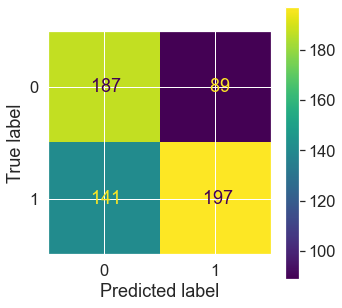

In [67]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgb,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [68]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.57      0.68      0.62       276
           1       0.69      0.58      0.63       338

    accuracy                           0.63       614
   macro avg       0.63      0.63      0.63       614
weighted avg       0.64      0.63      0.63       614



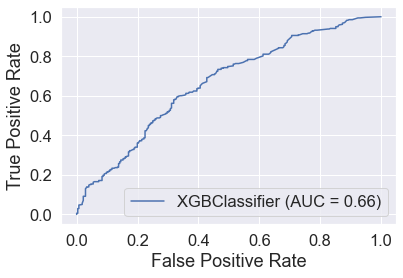

In [69]:
plot_roc_curve(xgb,X_test,y_test)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

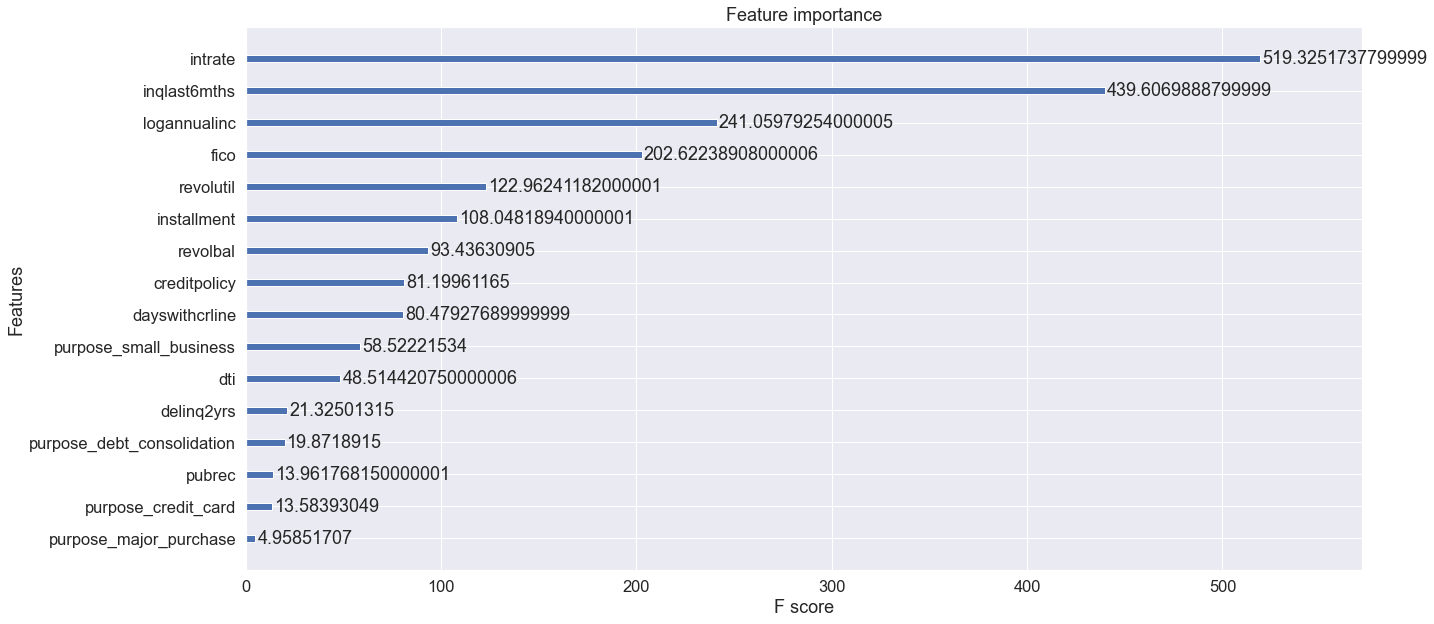

In [70]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgb,ax=ax,importance_type='total_gain')
plt.show()

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [71]:
cv = cross_val_score(xgb,X,y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [72]:
cv.mean()

0.605338725018731

### Feature Selection

In [75]:
df5.columns

Index(['intrate', 'installment', 'logannualinc', 'dti', 'fico',
       'dayswithcrline', 'revolbal', 'revolutil', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_major_purchase',
       'purpose_small_business', 'creditpolicy', 'inqlast6mths', 'delinq2yrs',
       'pubrec', 'notfullypaid'],
      dtype='object')

In [76]:
df6 = df5[['intrate','fico','inqlast6mths','installment','revolutil','logannualinc','notfullypaid']]

In [77]:
df6

,intrate,fico,inqlast6mths,installment,revolutil,logannualinc,notfullypaid
0,0.535358,0.151899,2.0,0.165953,0.846009,0.420395,1
1,0.206153,0.607595,1.0,0.299816,0.060094,0.731944,1
2,0.465042,0.329114,1.0,0.167369,0.598122,0.485460,1
3,0.499401,0.177215,1.0,0.075651,0.830986,0.233850,1
4,0.632042,0.227848,0.0,0.210940,0.179343,0.392225,1
...,...,...,...,...,...,...,...
3061,0.661606,0.379747,0.0,0.938408,0.719249,1.000000,0
3062,0.216540,0.734177,0.0,0.690373,0.032864,0.247559,1
3063,0.687175,0.379747,5.0,0.366763,0.497653,0.589618,1
3064,0.493008,0.303797,0.0,0.160872,0.702347,0.431780,0


In [78]:
X = df6.iloc[:,0:6]
y = df6.iloc[:,6]

In [79]:
X.values, y.values

(array([[0.53535757, 0.15189873, 2.        , 0.16595329, 0.84600939,
         0.42039476],
        [0.20615262, 0.60759494, 1.        , 0.29981562, 0.0600939 ,
         0.73194399],
        [0.46504195, 0.32911392, 1.        , 0.16736907, 0.59812207,
         0.48546049],
        ...,
        [0.68717539, 0.37974684, 5.        , 0.36676325, 0.49765258,
         0.58961755],
        [0.49300839, 0.30379747, 0.        , 0.16087186, 0.70234742,
         0.43177967],
        [0.41869756, 0.25316456, 0.        , 0.23812503, 0.36056338,
         0.27244591]]),
 array([1, 1, 1, ..., 1, 0, 0], dtype=int64))

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [81]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2452, 6), (614, 6), (2452,), (614,))

In [82]:
xgb2 = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [83]:
xgb2.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.413681
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.394137
[2]	validation_0-error:0.431596
[3]	validation_0-error:0.412052
[4]	validation_0-error:0.395765
[5]	validation_0-error:0.413681
[6]	validation_0-error:0.413681
[7]	validation_0-error:0.408795
[8]	validation_0-error:0.415309
[9]	validation_0-error:0.405537
[10]	validation_0-error:0.40228
[11]	validation_0-error:0.416938
Stopping. Best iteration:
[1]	validation_0-error:0.394137



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [84]:
y_pred = xgb2.predict(X_test)

In [85]:
y_pred

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,

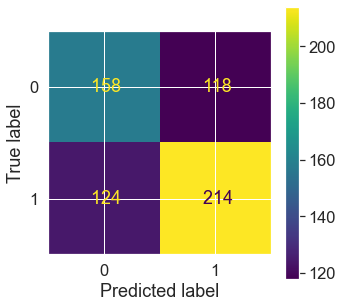

In [86]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgb2,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [87]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.56      0.57      0.57       276
           1       0.64      0.63      0.64       338

    accuracy                           0.61       614
   macro avg       0.60      0.60      0.60       614
weighted avg       0.61      0.61      0.61       614



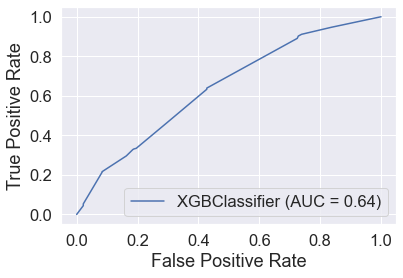

In [88]:
plot_roc_curve(xgb2,X_test,y_test)
plt.show()

### Summary: Not much difference

### Model Tuning

In [89]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [90]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [91]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, n_jobs=-1,
                           scoring='accuracy')

In [92]:
randm.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [93]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=8,
              learning rate=0.08, learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7, verbosity=1)

In [94]:
randm.best_score_

0.6173998756582408

In [95]:
randm.best_params_

{'subsample': 0.7,
 'n_estimators': 100,
 'min_child_weight': 2,
 'max_depth': 4,
 'learning rate': 0.08,
 'gamma': 8,
 'colsample_bytree': 0.5}

### Final Model

In [96]:
xgbnew = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic',max_depth=4,
                      gamma=8, min_child_weight=2,subsample=0.7,learning_rate=0.08,colsample_bytree=0.5)

In [97]:
xgbnew.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.408795
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.392508
[2]	validation_0-error:0.395765
[3]	validation_0-error:0.399023
[4]	validation_0-error:0.394137
[5]	validation_0-error:0.395765
[6]	validation_0-error:0.392508
[7]	validation_0-error:0.399023
[8]	validation_0-error:0.400651
[9]	validation_0-error:0.395765
[10]	validation_0-error:0.397394
[11]	validation_0-error:0.399023
Stopping. Best iteration:
[1]	validation_0-error:0.392508



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=8,
              learning_rate=0.08, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [98]:
y_pred = xgbnew.predict(X_test)

In [99]:
y_pred

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

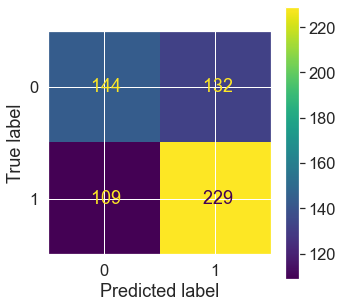

In [100]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgbnew,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [101]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.57      0.52      0.54       276
           1       0.63      0.68      0.66       338

    accuracy                           0.61       614
   macro avg       0.60      0.60      0.60       614
weighted avg       0.61      0.61      0.61       614



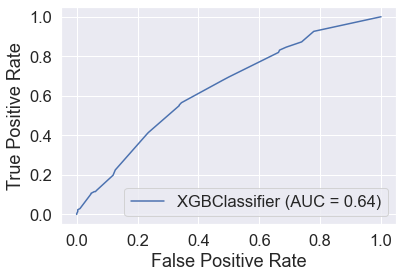

In [102]:
plot_roc_curve(xgbnew,X_test,y_test)
plt.show()